## Description

This data was acquired using web scraping techniques to pull from github based on search results from the word "repository". After obtaining the repo name, primary coding language, and readme contents, I processed the readme data into a form that would be easier to use natural language methods on. The goal here being to predict the primary coding language based on the contents of the readme. 

## Findings

- It was found that Python, Java, and C++ were the most common coding languages
- Only about a third of the repositories had specific coding languages mentioned in their readmes
- The common words found in each coding language group varied from group to group
- The best performing model (KNN) beat my baseline by 19% 

## Packages

In [1]:
from requests import get
import numpy as np
from bs4 import BeautifulSoup
import bs4
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import requests
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import prepare
import acquire

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from env import github_token, github_username

headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samkeeler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samkeeler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Acquire

In [2]:
''' Acquires the data via a saved csv, or if that is not present runs the scrape_github_data function '''

df = acquire.get_repo_data(cached = True)

## Prepare

In [3]:
''' 
Takes in readme contents and applies the make_prepped_columns() function. Drops altered readme 
columns with the exception of the lemmatized one (as that's what I'll be working with) and the original.
Also gets rid of rows containing null readme or null language columns. Drops rows if their respective language 
appears less than twice (can't split it). Removes stopwords.
'''

df = prepare.prep_repos(df)

'''
Adds a feature that searches the readme for mentions of a specific coding language and extracts it, then puts that 
language into the "languages_in_readme" column. Dummies are then created for each language found. Also adds a 
feature for "readme_length"
'''

df = prepare.add_language_dummies_and_length_feature(df)

In [4]:
df.head()

,repo,language,readme_contents_clean,readme_length,languages_in_readme,has_python,has_php,has_html,has_typescript,has_ruby,has_shell,has_c++,has_java,has_javascript,has_go
0,CloudCompare/CloudCompare,C++,cloudcomparehomepage httpscloudcompareorggithu...,1524,NaN,0,0,0,0,0,0,0,0,0,0
1,vispy/vispy,Python,vispy interactive scientific visualization pyt...,4014,NaN,0,0,0,0,0,0,0,0,0,0
2,mootools/mootools-core,JavaScript,mootools corebuild statushttpstravisciorgmooto...,3330,NaN,0,0,0,0,0,0,0,0,0,0
3,CodeMazeBlog/async-repository-dotnetcore-webapi,C#,async aspnet core web api httpscodemazecomasyn...,71,NaN,0,0,0,0,0,0,0,0,0,0
4,webpack/webpack.js.org,JavaScript,div aligncenter hrefhttpsgithubcomwebpackwebpa...,2448,NaN,0,0,0,0,0,0,0,0,0,0


## Split

In [5]:
# Splits the data into train, validate, and test

train, validate, test = prepare.split(df, stratify_by = 'language')

## Explore

In [6]:
# Seeing how often each language appears in the dataset

df.language.value_counts()

Python              21
Java                20
C++                 16
PHP                 15
JavaScript          13
Shell               13
C#                  11
C                   10
HTML                10
Ruby                 9
Jupyter Notebook     4
Go                   3
TypeScript           3
Name: language, dtype: int64

<AxesSubplot:title={'center':'Coding Language Distribution'}, xlabel='language', ylabel='count'>

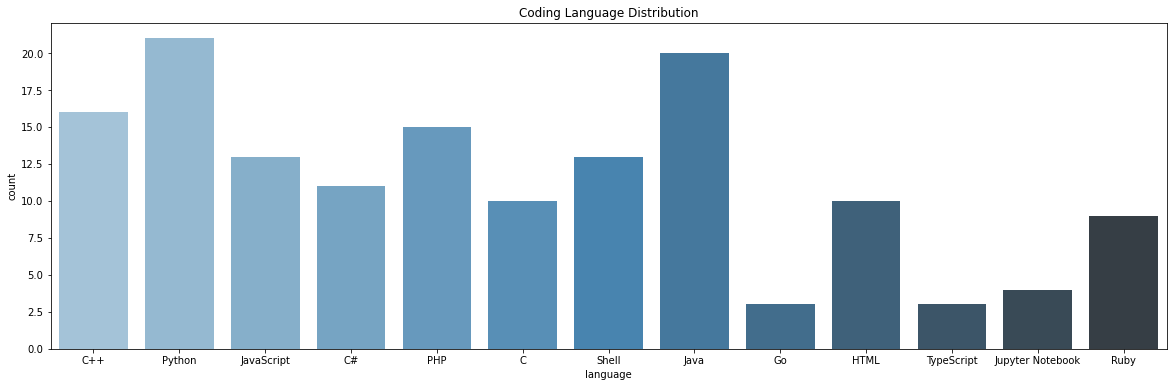

In [7]:
# Now I visualize the language distributions

plt.subplots(figsize = (20, 6))
plt.title('Coding Language Distribution')
sns.countplot(x="language", data=df,
                 palette="Blues_d")

<AxesSubplot:title={'center':'All Words Distribution'}, xlabel='Top Words', ylabel='Count'>

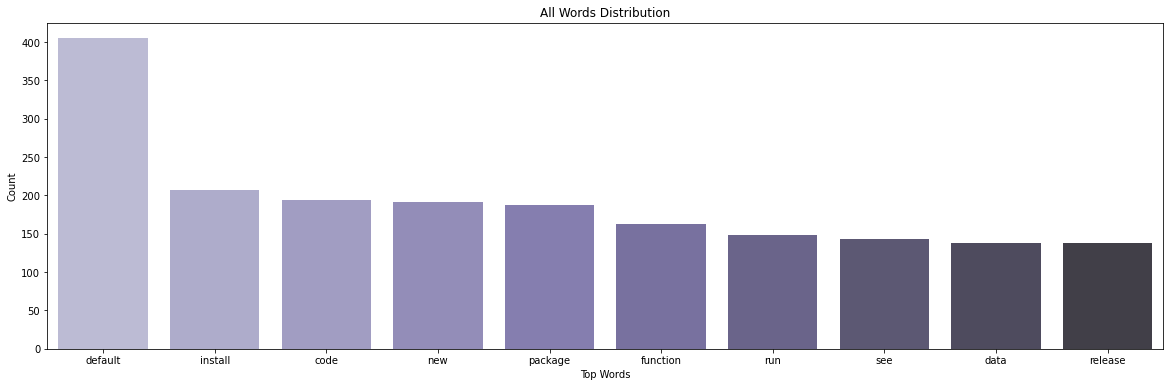

In [8]:
# Finding the top words from all of the readme's combined

the_words = ' '.join(df.readme_contents_clean)
all_freq = pd.Series(the_words.split(' ')).value_counts()

all_word_freq = pd.DataFrame(all_freq, columns =['Count'])
all_word_freq = all_word_freq.reset_index()
all_word_freq = all_word_freq.rename(columns = {'index':'Top Words'})

plt.subplots(figsize = (20, 6))
plt.title('All Words Distribution')
sns.barplot(x="Top Words", y='Count', data=all_word_freq.head(10),
                 palette="Purples_d")

In [9]:
# Viewing the top words of the three most frequent coding languages in the dataset

python_words = ' '.join(train[train.language == 'Python'].readme_contents_clean)
java_words = ' '.join(train[train.language == 'Java'].readme_contents_clean)
cplusplus_words = ' '.join(train[train.language == 'C++'].readme_contents_clean)

python_freq = pd.Series(python_words.split(' ')).value_counts()
java_freq = pd.Series(java_words.split(' ')).value_counts()
cplusplus_freq = pd.Series(cplusplus_words.split(' ')).value_counts()

print('Popular Words in Python'), print(python_freq.head()), print(f"\n"), print('Popular Words in Java'),
print(java_freq.head()), print("\n"),print('Popular Words in C++'), print(cplusplus_freq.head())

Popular Words in Python
module    67
code      33
depth     31
python    30
new       30
dtype: int64


Popular Words in Java
server     40
project    28
nexus      28
public     26
update     23
dtype: int64


Popular Words in C++
cmake      29
release    24
project    22
library    22
install    21
dtype: int64


(None, None, None, None)

<AxesSubplot:title={'center':'Python Word Distribution'}, xlabel='Top Words', ylabel='Count'>

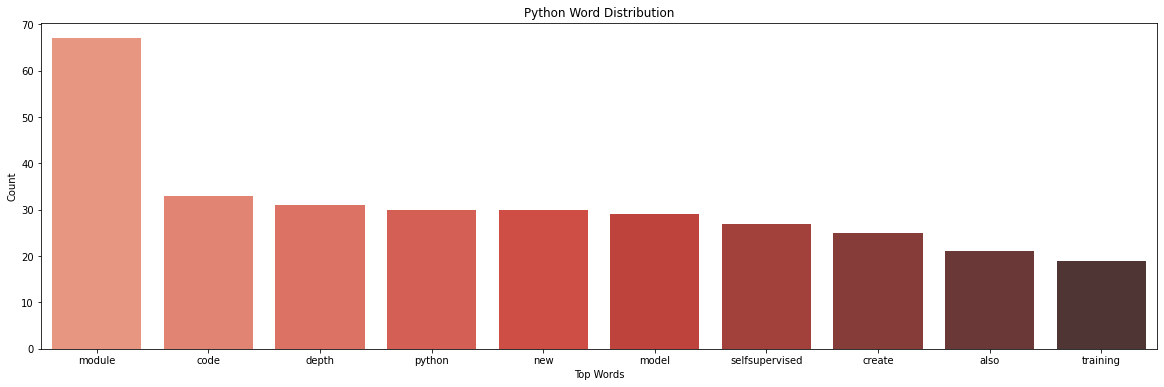

In [10]:
# Showing a distribution of the top words used in readmes where the repo's main language was python

py_word_freq = pd.DataFrame(python_freq, columns =['Count'])
py_word_freq = py_word_freq.reset_index()
py_word_freq = py_word_freq.rename(columns = {'index':'Top Words'})

plt.subplots(figsize = (20, 6))
plt.title('Python Word Distribution')
sns.barplot(x="Top Words", y='Count', data=py_word_freq.head(10),
                 palette="Reds_d")

<AxesSubplot:title={'center':'Java Word Distribution'}, xlabel='Top Words', ylabel='Count'>

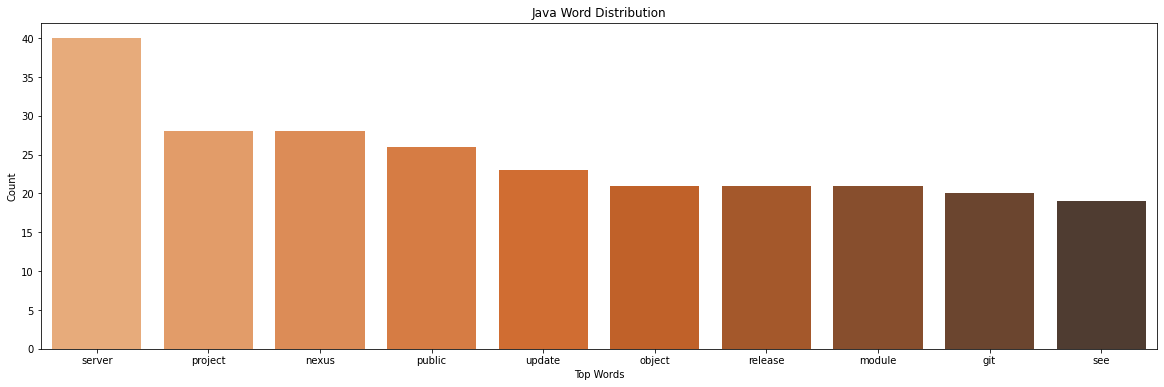

In [11]:
# Showing a distribution of the top words used in readmes where the repo's main language was java

java_word_freq = pd.DataFrame(java_freq, columns =['Count'])
java_word_freq = java_word_freq.reset_index()
java_word_freq = java_word_freq.rename(columns = {'index':'Top Words'})

plt.subplots(figsize = (20, 6))
plt.title('Java Word Distribution')
sns.barplot(x="Top Words", y='Count', data=java_word_freq.head(10),
                 palette="Oranges_d")

<AxesSubplot:title={'center':'C++ Word Distribution'}, xlabel='Top Words', ylabel='Count'>

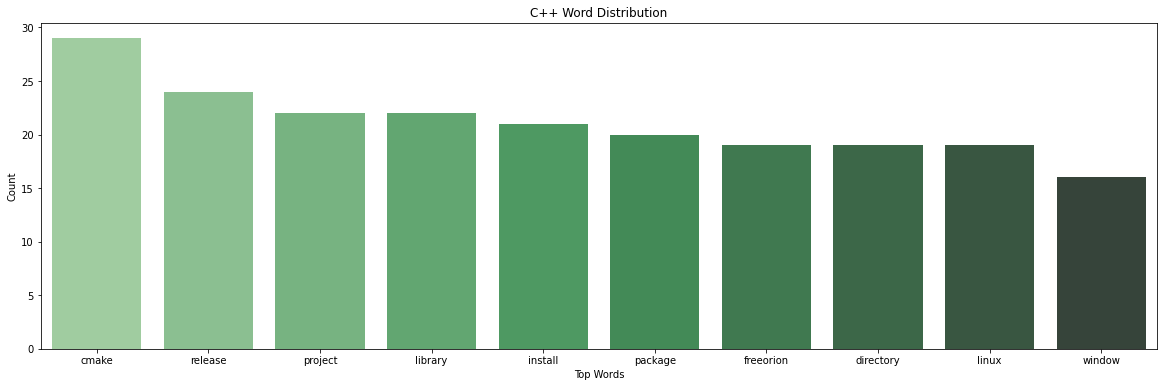

In [12]:
# Showing a distribution of the top words used in readmes where the repo's main language was C++

cpl_word_freq = pd.DataFrame(cplusplus_freq, columns =['Count'])
cpl_word_freq = cpl_word_freq.reset_index()
cpl_word_freq = cpl_word_freq.rename(columns = {'index':'Top Words'})

plt.subplots(figsize = (20, 6))
plt.title('C++ Word Distribution')
sns.barplot(x="Top Words", y='Count', data=cpl_word_freq.head(10),
                 palette="Greens_d")

In [13]:
# Surprisingly there was a significant difference in the words used from coding language to coding language. 
# Among the top 3 coding language's top 10 words, only two words were present in more than one language (project 
# and module)

In [14]:
# Viewing the average readme length grouped by coding language. There is a large amount of variance in the
# readme lengths

language_lengths = train.groupby('language').readme_length.mean().sort_values(ascending = False)
language_lengths

language
Go                  4902.000000
Java                3935.181818
Ruby                3480.000000
C++                 3206.222222
Python              2824.833333
C                   2806.833333
C#                  2754.500000
JavaScript          2471.714286
PHP                 2165.500000
HTML                2071.333333
TypeScript          1549.000000
Jupyter Notebook    1311.000000
Shell                717.857143
Name: readme_length, dtype: float64

<AxesSubplot:title={'center':'Mean Readme Length By Language'}, xlabel='Programming Language', ylabel='Readme Length (characters)'>

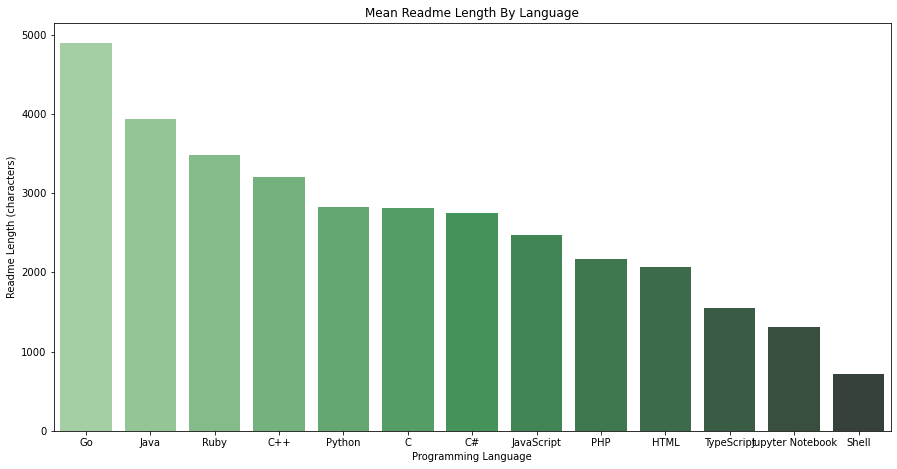

In [15]:
# Now I'm gonna visualize it

lang_length_df = pd.DataFrame(language_lengths)
lang_length_df = lang_length_df.reset_index()
lang_length_df = lang_length_df.rename(columns = {'language': 'Programming Language',
                                                  'readme_length': 'Readme Length (characters)'})
plt.subplots(figsize = (15, 7.5))
plt.title('Mean Readme Length By Language')
sns.barplot(x='Programming Language', y='Readme Length (characters)', data=lang_length_df,
                 palette="Greens_d")



In [20]:
# A sample of repos that had languages listed in the readme

df[df['languages_in_readme'].notnull()].head(8)

,repo,language,readme_contents_clean,readme_length,languages_in_readme,has_python,has_php,has_html,has_typescript,has_ruby,has_shell,has_c++,has_java,has_javascript,has_go
5,WPO-Foundation/webpagetest,PHP,webpagetesttravishttpsimgshieldsiotraviswpofou...,1100,"' python ', ' php '",1,1,0,0,0,0,0,0,0,0
7,angular/material-start,JavaScript,angularjs materialstart es6gitterhttpsbadgesgi...,4240,"' html ', ' typescript'",0,0,1,1,0,0,0,0,0,0
8,transmission/transmission,C,abouttransmission fast easy free bittorrent cl...,1818,' shell ',0,0,0,0,0,1,0,0,0,0
10,tegon/clone-org-repos,JavaScript,clone github organization reposnpmhttpsnodeico...,2562,' ruby ',0,0,0,0,1,0,0,0,0,0
13,geotools/geotools,Java,geotools logogeotoolslogopnggeotoolshttpgeotoo...,1252,' java ',0,0,0,0,0,0,0,1,0,0
17,DSpace/xoai,Java,xoaiwhat xoaixoai powerful flexible oaipmh jav...,784,' java ',0,0,0,0,0,0,0,1,0,0
19,cpina/github-action-push-to-another-repository,Shell,githubactionpushtoanotherrepositorywhen github...,2916,' go ',0,0,0,0,0,0,0,0,0,1
28,offensive-security/exploitdb,C,exploit database git repositorythis official e...,5755,' python ',1,0,0,0,0,0,0,0,0,0


## Prep for Modeling

In [ ]:
# Splits the data into train, validate, and test
df.drop(columns = ['languages_in_readme', 'repo'], inplace = True)
train, validate, test = prepare.split(df, stratify_by = 'language')

In [ ]:
# Splitting from target variable for creating models

X_train = train.drop(columns = ['language'])
X_validate = validate.drop(columns = ['language'])
X_test = test.drop(columns = ['language'])

In [ ]:
# Creating target variable groups for creating models

y_train = train.language
y_validate = validate.language
y_test = test.language

In [ ]:
# Creating a vectorizer object 

tfidf = TfidfVectorizer()

# Fitting that object onto the train data

tfidf.fit(X_train.readme_contents_clean)

# Applying the vector transformer to each data set

X_train_vectorized = tfidf.transform(X_train.readme_contents_clean)
X_validate_vectorized = tfidf.transform(X_validate.readme_contents_clean)
X_test_vectorized = tfidf.transform(X_test.readme_contents_clean)

In [ ]:
# Creating a dataframe that will hold predicted and actual values for evaluation metrics

train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

## Modeling

In [ ]:
# Establishing a baseline

print('Baseline Accuracy:', round((21/len(df)), 3))

## Logistic Regression

In [ ]:
# Creating and fitting the logistic regression model

lm = LogisticRegression()
lm.fit(X_train_vectorized, y_train)

In [ ]:
# Applying and evaluating the logistic regression model

train['predicted_logreg'] = lm.predict(X_train_vectorized)
validate["predicted_logreg"] = lm.predict(X_validate_vectorized)
print('Train:', (train.actual == train.predicted_logreg).mean()), print('Validate:', (validate.actual == validate.predicted_logreg).mean())

## Gaussian Naive Bayes

In [ ]:
# Creating and fitting the naive bayes model

gnb = GaussianNB()
gnb.fit(X_train_vectorized.toarray(), y_train)

In [ ]:
# Applying and evaluating the naive bayes model

train['predicted_gnb'] = gnb.predict(X_train_vectorized.toarray())
validate['predicted_gnb'] = gnb.predict(X_validate_vectorized.toarray())
print('Train:', (train.actual == train.predicted_gnb).mean()), print('Validate:', (validate.actual == validate.predicted_gnb).mean())

## Random Forest

In [ ]:
# Creating and fitting the random forest model

rf = RandomForestClassifier(max_depth = 8, min_samples_leaf = 3, random_state=123)
rf.fit(X_train_vectorized, y_train)

In [ ]:
# Applying and evaluating the random forest model

train['predicted_rf'] = rf.predict(X_train_vectorized.toarray())
validate['predicted_rf'] = rf.predict(X_validate_vectorized.toarray())
print('Train:', (train.actual == train.predicted_rf).mean()), print('Validate:', (validate.actual == validate.predicted_rf).mean())

## KNN

In [ ]:
# Creating and fitting the KNN model

kn = KNeighborsClassifier(n_neighbors=6, weights='uniform')
kn = kn.fit(X_train_vectorized.toarray(), y_train)

In [ ]:
# Applying and evaluating the KNN model

train['predicted_knn'] = kn.predict(X_train_vectorized.toarray())
validate['predicted_knn'] = kn.predict(X_validate_vectorized.toarray())
print('Train:', (train.actual == train.predicted_knn).mean()), print('Validate:', (validate.actual == validate.predicted_knn).mean())

## Testing on KNN

In [ ]:
# Since KNN is my best performing model on validate, I'm gonna go ahead and test on it

test['predicted_knn'] = kn.predict(X_test_vectorized.toarray())

In [ ]:
print('Test Performance:', (test.actual == test.predicted_knn).mean())

A performance more than twice as good as the baseline is a great improvement!